<a href="https://colab.research.google.com/github/farenga/neuralODE/blob/main/jax_neuralode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import jax.numpy as jnp
import numpy.random as npr
from jax import jit, grad
from jax.experimental.ode import odeint


In [20]:
def mlp(params, inputs):
  for w,b in params:
    outputs = jnp.dot(inputs,w)+b
    inputs = jnp.tanh(outputs)
  return outputs

In [21]:
def resnet(params, inputs, depth):
  for i in range(depth):
    outputs = mlp(params,inputs) + inputs
  return outputs

In [22]:
resnet_depth = 3

def resnet_squared_loss(params,inputs,targets):
  preds = resnet(params,inputs,resnet_depth)
  return jnp.mean(jnp.sum((preds-targets)**2,axis=1))

def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
  return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

@jit
def resnet_update(params, inputs, targets):
  grads = grad(resnet_squared_loss)(params, inputs, targets)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

Text(0, 0.5, 'output')

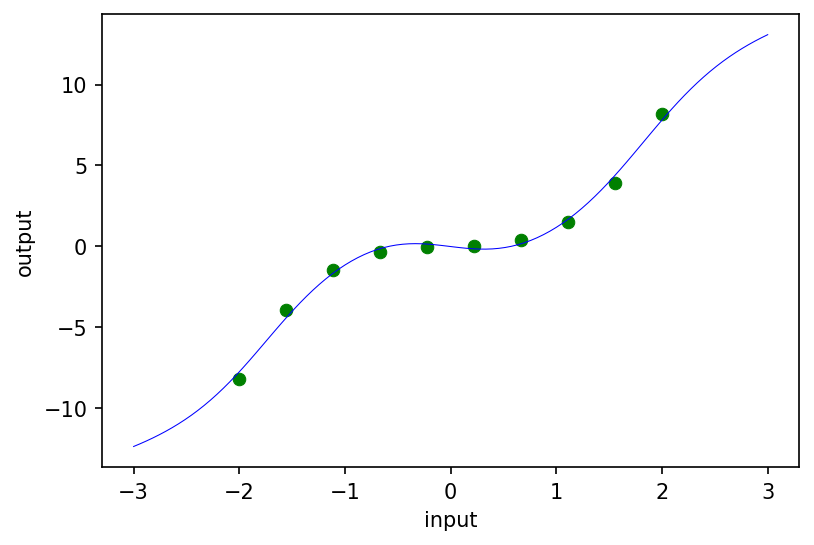

In [23]:
inputs = jnp.reshape(jnp.linspace(-2.0, 2.0, 10), (10, 1))
targets = inputs**3 + 0.1 * inputs

# Hyperparameters.
layer_sizes = [1, 20, 1]
param_scale = 1.0
step_size = 0.01
train_iters = 1000

# Initialize and train.
resnet_params = init_random_params(param_scale, layer_sizes)
for i in range(train_iters):
  resnet_params = resnet_update(resnet_params, inputs, targets)

# Plot results.
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth), lw=0.5, color='blue')
ax.set_xlabel('input')
ax.set_ylabel('output')

In [24]:
def nn_dynamics(state,time,params):
  state_and_time = jnp.hstack([state,jnp.array(time)])
  return mlp(params,state_and_time)

In [25]:
def odenet(params, input):
  start_and_end_times = jnp.array([0.0, 1.0])
  init_state, final_state = odeint(nn_dynamics, input, start_and_end_times, params)
  return final_state

In [26]:
from jax import vmap
batched_odenet = vmap(odenet, in_axes=(None, 0))

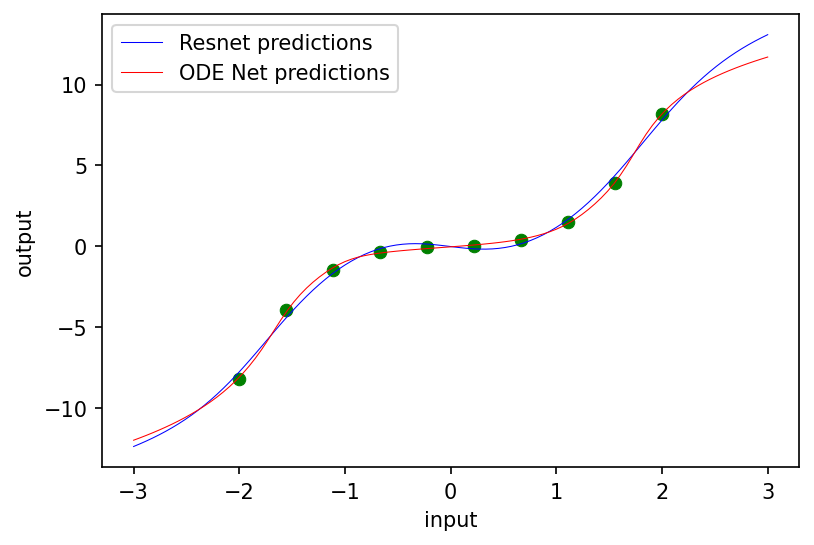

In [27]:
odenet_layer_sizes = [2, 20, 1]

def odenet_loss(params, inputs, targets):
  preds = batched_odenet(params, inputs)
  return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

@jit
def odenet_update(params, inputs, targets):
  grads = grad(odenet_loss)(params, inputs, targets)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

# Initialize and train ODE-Net.
odenet_params = init_random_params(param_scale, odenet_layer_sizes)

for i in range(train_iters):
  odenet_params = odenet_update(odenet_params, inputs, targets)

# Plot resulting model.
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth), lw=0.5, color='blue')
ax.plot(fine_inputs, batched_odenet(odenet_params, fine_inputs), lw=0.5, color='red')
ax.set_xlabel('input')
ax.set_ylabel('output')
plt.legend(('Resnet predictions', 'ODE Net predictions'))

Text(0, 0.5, 'time / depth')

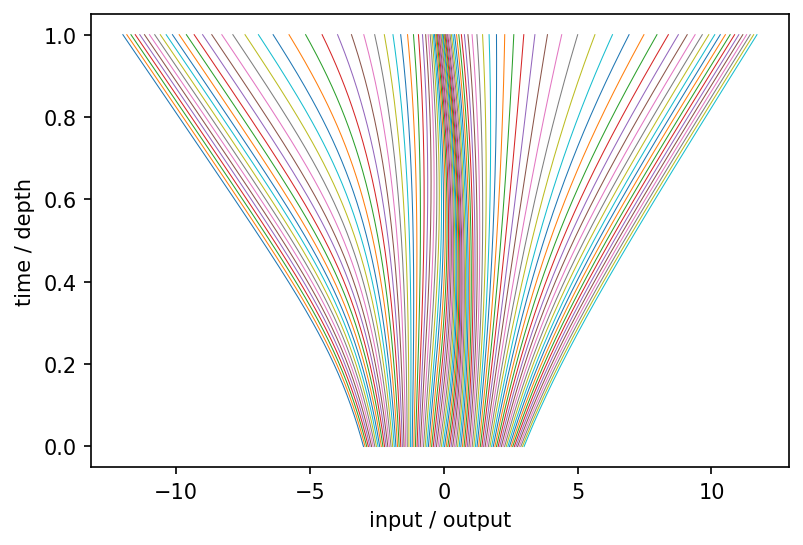

In [28]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()

@jit
def odenet_times(params, input, times):
  def dynamics_func(state, time, params):
    return mlp(params, jnp.hstack([state, jnp.array(time)]))
  return odeint(dynamics_func, input, times, params)

times = jnp.linspace(0.0, 1.0, 200)

for i in fine_inputs:
  ax.plot(odenet_times(odenet_params, i, times), times, lw=0.5)

ax.set_xlabel('input / output')
ax.set_ylabel('time / depth')